# 数据导入

In [2]:
# for numercial computing in python and multiple dimension array | and plot
import numpy as np
import matplotlib.pyplot as plt

# Import the maching learning tools
# import pipeline for create a sequence of data processing steps in a pipeline.
# pipeline to combine all the models together and to extract the features | LDA for classification|model_selection for split the data sets
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

# mne package for import the tools for processing EEG data
from mne import Epochs, pick_types, events_from_annotations
'''
Epochs is used for extracting short segements from continuous EEG recordings, typically around specific events
pick_types is used to select specific types of EEG chennels (usually pick the good channels from the bad channels)
events_from_annotations is used to extract events from annotations in EEG data
'''
# for reading sensor layout imformation
from mne.channels import read_layout, make_standard_montage

# for reading and concatenating EEG data | concatenate for combine multiple EEG recordings | read EEG data in the edf format
from mne.io import concatenate_raws, read_raw_edf

# imports the EEGBCI dataset from MNE, a dataset that is public free and can be download through MNE website
from mne.datasets import eegbci
# import Common Spatial Patterns, which is a technique for extracting features from EEG signals
from mne.decoding import CSP



###############################################################################
tmin, tmax = -1., 4.  #设置参数，记录点的前1秒后4秒用于生成epoch数据
event_id = dict(hands=2, feet=3) #设置事件的映射关系, what "hands" movements are mapped to 2 and "feet" movements are mapped to 3
subject = 1 # could change from 1 to 109 选择一个受试者
runs = range(1,10) # 指定要从受试者中夹菜哪些运行运行或者会话的数据。这边指的是运行 6 10 14 会话数据。


# 获取想要读取的文件名称，这个应该是没有会默认下载的数据
# mne.datasets.eegbci.load_data(subject, runs, path=None, force_update=False, update_path=None, base_url='https://physionet.org/files/eegmmidb/1.0.0/', verbose=None)
raw_fnames = eegbci.load_data(subject, runs)
# 将3个文件的数据进行拼接
# raw 应该是一个包含多个MNE Raw对象的列表。这些Raw对象代表着不同的EEG数据段，函数的目的是为了将这些数据段合并成一个完整的数据流
# mne.concatenate_raws(raws 这个是需要合并的 list, preload=None, events_list=None, *, on_mismatch='raise', verbose=None)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
print('----')
channel_names = raw.info
print(channel_names)

eegbci.standardize(raw)
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# 去掉通道名称后面的（.），不知道为什么默认情况下raw.info['ch_names']中的通道名后面有的点
raw.rename_channels(lambda x: x.strip('.'))
# 对原始数据进行FIR带通滤波 加一个点的意思是浮点数而不是int 使用浮点数而不是整数对于频率滤波来说可以提高更高的精度
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
# 这里可以看到高通是7Hz，低通是30Hz
print(raw.info)


# 从annotation中获取事件信息
# mne.events_from_annotations(raw, event_id='auto', regexp='^(?![Bb][Aa][Dd]|[Ee][Dd][Gg][Ee]).*$', use_rounding=True, chunk_duration=None, verbose=None)
# regexp 里面的内容通常为正则表达式，用来筛选注释。在这个例子当中，一般用来判处以bad或者edge开头的注释，因为这些通常表示为坏段，边缘等，并不是真正的事件。
# eventid 这个参数是一个字典，用来定义将注释的比如在这边是T1 T2 映射到数值事件（我们之前定义过了）T1 为hands T2 为feet
# 我们之前将手设置为1，将脚设置为2，这行代码的目的就是为了将EEG数据中依据注释提取事件信息，将这些信息转换为事件数组（2，3）
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
# 剔除坏道，提取其中有效的EEG数据
# mne.pick_types(info, meg=False, eeg=False, stim=False, eog=False, ecg=False, emg=False, ref_meg='auto', *, misc=False, resp=False, chpi=False, exci=False, ias=False, syst=False, seeg=False, dipole=False, gof=False, bio=False, ecog=False, fnirs=False, csd=False, dbs=False, temperature=False, gsr=False, eyetrack=False, include=(), exclude='bads', selection=None)
# 函数返回一个包含所选通道的数组，数组包含了选择的通道的编号
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
print("(----)")
print(picks)
# 根据事件生成对应的Epochs数据
# class mne.Epochs(raw, events, event_id=None, tmin=-0.2, tmax=0.5, baseline=(None, 0), picks=None, preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, reject_tmax=None, detrend=None, on_missing='raise', reject_by_annotation=True, metadata=None, event_repeated='error', verbose=None)
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)


# 截取其中的1秒到2秒之间的数据，也就是提示音后1秒到2秒之间的数据（这个在后面滑动窗口验证的时候有用）
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
# 将events转换为labels,event为2,3经过计算后也就是0,1
labels = epochs.events[:, -1] - 2



Extracting EDF parameters from /Users/calvin-xu/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /Users/calvin-xu/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /Users/calvin-xu/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/calvin-xu/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.99

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


# 利用CSP提取特征，建立线性分类器

[[[-2.66419410e-05 -2.26638421e-05 -1.80047632e-05 ... -1.54885875e-05
   -1.97880283e-05 -2.45737998e-05]
  [-2.85933369e-05 -2.96655074e-05 -2.07489907e-05 ... -9.18724568e-06
   -7.02265659e-06 -1.06211354e-05]
  [-2.43538059e-05 -2.80508206e-05 -1.97124084e-05 ... -7.23135300e-06
   -1.73041670e-06 -3.74526786e-06]
  ...
  [-4.70418362e-06 -5.35977905e-06  1.69877366e-06 ... -1.74199794e-05
   -1.01970129e-05 -8.24348403e-06]
  [-4.13423738e-06 -1.48512669e-05 -1.26741625e-05 ... -2.86456343e-05
   -2.37964472e-05 -1.52058503e-05]
  [-2.29762695e-05 -1.71437132e-05 -8.09289593e-07 ... -2.28741778e-05
   -1.23821173e-05 -7.16242400e-06]]

 [[-1.11063426e-05 -1.53489558e-05 -2.11206016e-05 ...  3.97955059e-06
    4.61590865e-06  1.13350069e-06]
  [-7.52324194e-06 -9.22168066e-06 -1.54195768e-05 ...  2.90126469e-06
    6.60348968e-06  7.47763245e-06]
  [-3.18072318e-06 -1.67861839e-06 -7.85897221e-06 ... -4.16389643e-07
    6.20111258e-06  1.10385859e-05]
  ...
  [-1.13797826e-05  2.6

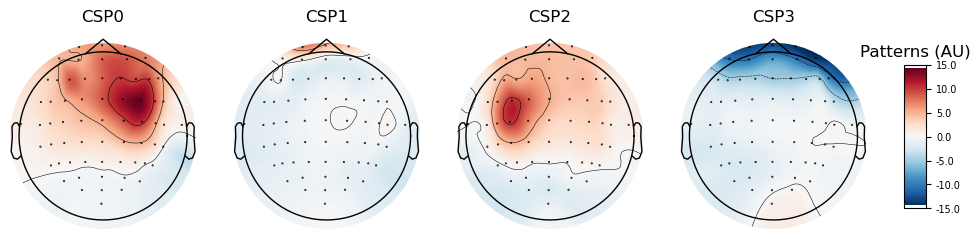

In [3]:
###########################第二部分，特征提取和分类####################################################
scores = []

# 获取epochs的所有数据，主要用于后面的滑动窗口验证
epochs_data = epochs.get_data()
# 返回了EEG数组用于观测
print(epochs_data)

# 获取训练数据
epochs_data_train = epochs_train.get_data()

# 设置交叉验证模型的参数
cv = ShuffleSplit(10, test_size=0.2, random_state=42)

# 根据设计的交叉验证参数,分配相关的训练集和测试集数据
cv_split = cv.split(epochs_data_train)

# 创建线性分类器
lda = LinearDiscriminantAnalysis()

# 创建CSP提取特征，这里使用4个分量的CSP
csp = CSP(n_components=4, reg=None, log=False, norm_trace=False)

# 创建机器学习的Pipeline,也就是分类模型，使用这种方式可以把特征提取和分类统一整合到了clf中
clf = Pipeline([('CSP', csp), ('LDA', lda)])

# 获取交叉验证模型的得分
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# 输出结果，准确率和不同样本的占比
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))


# csp提取特征,用于绘制CSP不同分量的模式图（地形图）
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

# 算法性能验证

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

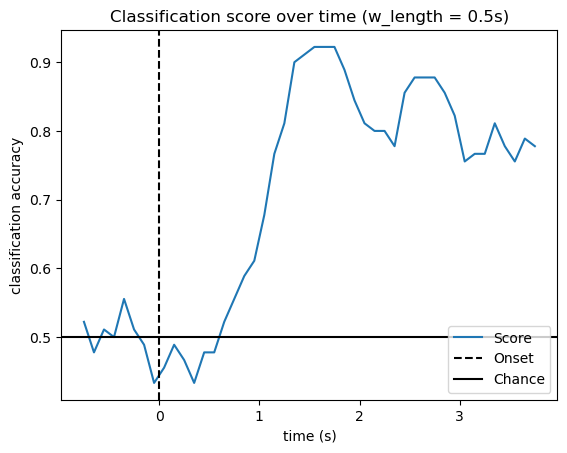

In [67]:
#########################验证算法的性能###########################################
# 获取数据的采样频率
sfreq = raw.info['sfreq']
# 设置滑动窗口的长度，也就是数据窗口的长度
w_length = int(sfreq * 0.5)
# 设置滑动步长，每次滑动的数据间隔
w_step = int(sfreq * 0.1)
# 每次滑动窗口的起始点
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
# 得分列表用于保存模型得分
scores_windows = []
# 交叉验证计算模型的性能
for train_idx, test_idx in cv_split:
    # 获取测试集和训练集数据
    y_train, y_test = labels[train_idx], labels[test_idx]
    # 设置csp模型的参数，提取相关特征，用于后面的lda分类
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    # 拟合lda模型
    lda.fit(X_train, y_train)
    # 用于记录本次交叉验证的得分
    score_this_window = []
    for n in w_start:
        # csp提取测试数据相关特征
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        # 获取测试数据得分
        score_this_window.append(lda.score(X_test, y_test))
    # 添加到总得分列表
    scores_windows.append(score_this_window)
 
# 设置绘图的时间轴，时间轴上的标志点为窗口的中间位置
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
# 绘制模型分类结果的性能图（得分的均值）
plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time (w_length = {0}s)'.format(w_length/sfreq))
plt.legend(loc='lower right')
plt.show()